# Testing the BoARIO package
This script runs the example used on the BoARIO documentation. It then attempts to customize the classes and event/shock. 

In [1]:
# import pymrio for the test MRIOT
import pymrio

# import the different classes
from boario.extended_models import ARIOPsiModel  # The core of the model

In [2]:
mriot = pymrio.load_test().calc_all()

/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/core/mriosystem.py:900: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Y_agg = Y.groupby(level="region", axis=1, sort=False).sum()
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/core/mriosystem.py:984: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_cba.groupby(level="region", axis=1, sort=False).sum()
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/core/mriosystem.py:993: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_pba.groupby(level="region", axis=1, sort=False).sum()
/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/pymrio/core/mriosystem.py:1001: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  self.D_imp_reg = self.D_imp.g

In [3]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
model = ARIOPsiModel(mriot)

/opt/anaconda3/envs/scmods/lib/python3.12/site-packages/boario/model_base.py:277: UserWarning: No capital to VA dictionary given, considering 4/1 ratio
  warnings.warn("No capital to VA dictionary given, considering 4/1 ratio")


In [23]:
from boario.simulation import Simulation  # Simulation wraps the model

sim = Simulation(model, n_temporal_units_to_sim=365)

In [24]:
from boario import event

# Instantiate an event.
ev = event.from_scalar_regions_sectors(
    impact=10000,
    event_monetary_factor=10**6,
    duration=15,
    event_type="rebuild",
    affected_regions=["reg3"],
    affected_sectors=["manufactoring", "mining"],
    impact_sectoral_distrib=model.mriot.x.loc["reg3", "indout"],
    impact_regional_distrib="equal",
    rebuilding_sectors={"construction": 0.55, "manufactoring": 0.45},
    rebuild_tau=180,
)

In [25]:
# Add the event to the simulation
sim.add_event(ev)

In [26]:
# Launch the simulation
sim.loop()

<Axes: xlabel='step'>

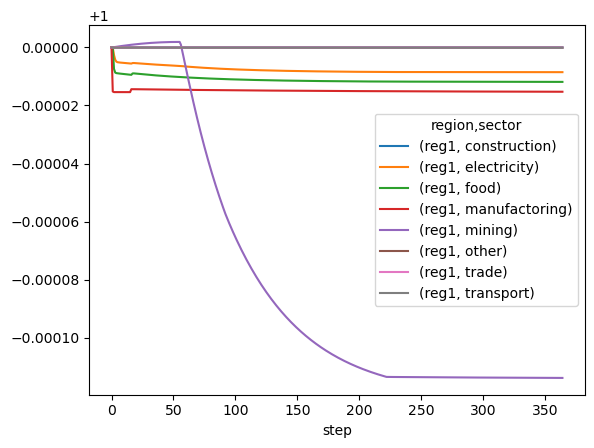

In [27]:
# You can generate a dataframe of
# the production with the following line
df = sim.production_realised
# This allows to normalize production at its initial level
df = df / df.loc[0]

df.loc[:, ("reg1", slice(None))].plot()